In [23]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.callbacks import CSVLogger





In [9]:
# Load the MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()
# Normalize the data
x_train = x_train.astype('float32') / 255.
print("Training samples:", x_train.shape[0])
print("Test samples:", x_test.shape[0])


input_shape = x_train.shape
print("Input shape:", input_shape)
# Flatten the data
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))


input_shape = (784,)

# Define the encoder
input_layer = Input(shape=input_shape)
encoded1 = Dense(128, activation='relu')(input_layer)
encoded2 = Dense(9, activation='relu')(encoded1)
# Define the decoder
decoded1 = Dense(9, activation='relu')(encoded2)
decoded2 = Dense(256, activation='relu')(decoded1)
decoded = Dense(784, activation='sigmoid')(decoded2)
# Define the autoencoder model
autoencoder = Model(input_layer, decoded)
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')
# Train the model
autoencoder.fit(x_train, x_train, epochs=20, batch_size=256, shuffle=True, validation_data=(x_test, x_test))


Training samples: 60000
Test samples: 10000
Input shape: (60000, 28, 28)
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0870 - val_loss: 13214.4668
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0297 - val_loss: 13208.8887
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0241 - val_loss: 13208.2168
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0226 - val_loss: 13207.6230
Epoch 5/20


KeyboardInterrupt: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step


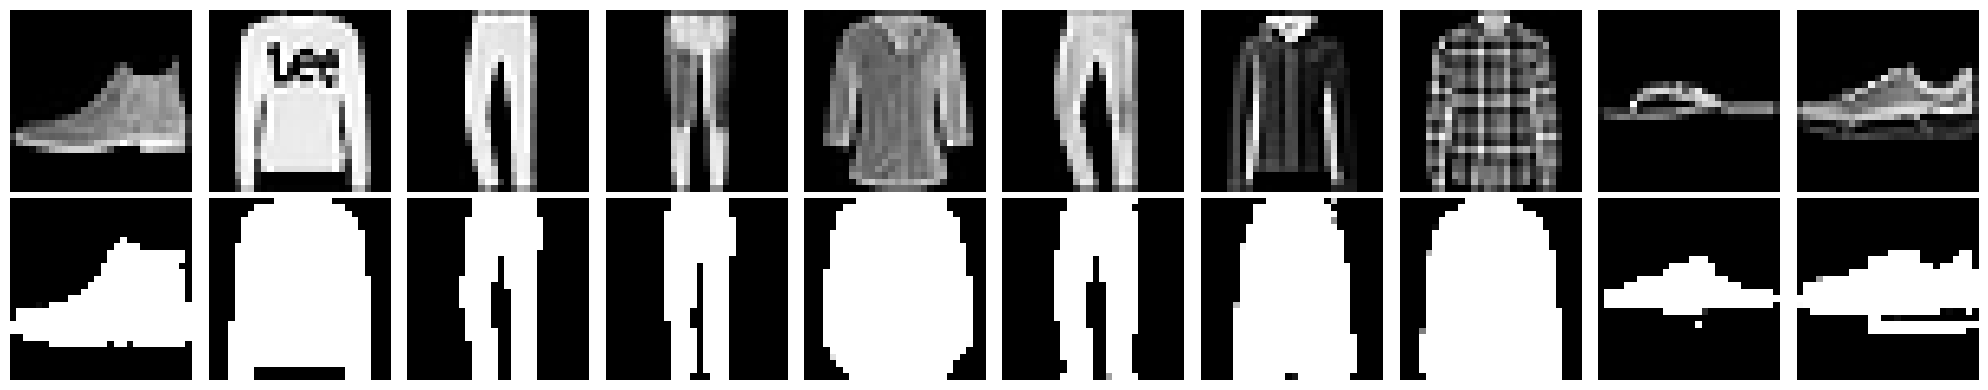

In [38]:
# Encode and decode the test set
decoded_imgs = autoencoder.predict(x_test)

# Plot the first 10 decoded images
portion_decoded_imgs = decoded_imgs[:10]

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

for i in range(10):
    # Plot input image
    axes[0, i].imshow(x_test[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    
    # Plot decoded image
    axes[1, i].imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [10]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


#build the encoder
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()



#Train VAE
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fmnist_data = np.concatenate([x_train, x_test], axis=0)
fmnist_data = np.expand_dims(fmnist_data, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fmnist_data, epochs=30, batch_size=128)




def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
220/547 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - kl_loss: 2.3671 - loss: 430.9595 - reconstruction_loss: 428.5923

KeyboardInterrupt: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


ValueError: cannot reshape array of size 3072 into shape (28,28)

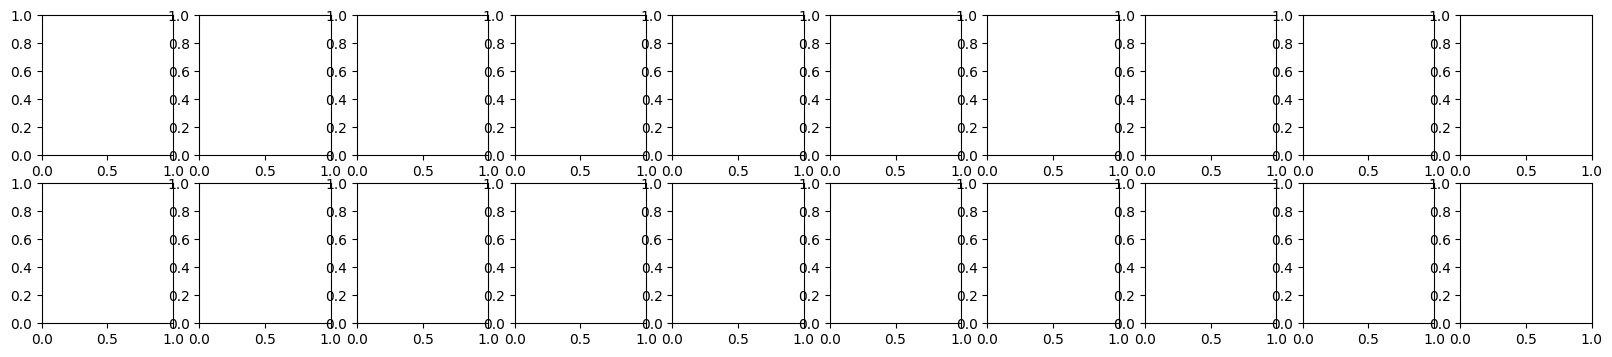

In [66]:
x_test_reshaped=np.expand_dims(x_test, -1).astype("float32") / 255

z_sample=vae.encoder.predict(x_test_reshaped)[2]

images=vae.decoder.predict(z_sample)

images.shape



# Select 10 indices
indices = np.arange(0,10)

# Plot the input vs output images
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

for i, idx in enumerate(indices):
    # Plot input image
    axes[0, i].imshow(x_test[idx].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    
    # Plot output image
    axes[1, i].imshow(images[idx].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [29]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



#build the encoder
latent_dim = 10

encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, (3,3), activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder_cifar = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder_cifar.summary()

#build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, (3,3), activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, (3,3), activation="sigmoid", padding="same")(x)
decoder_cifar = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder_cifar.summary()


# encoder_inputs = keras.Input(shape=(32, 32, 3))
# x = layers.Conv2D(32, (2,2), activation="relu", strides=(2,2), padding="same")(encoder_inputs)
# x = layers.Conv2D(32, (2,2), activation="relu", strides=(2,2), padding="same")(x)
# x = layers.Conv2D(32, (2,2), activation="relu", strides=1, padding="same")(x)
# x = layers.Conv2D(32, (2,2), activation="relu", strides=1, padding="same")(x)
# x = layers.Flatten()(x)
# x = layers.Dense(128, activation="relu")(x)
# z_mean = layers.Dense(latent_dim, name="z_mean")(x)
# z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
# z = Sampling()([z_mean, z_log_var])
# encoder_cifar = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder_cifar.summary()

# #build the decoder
# latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(32*16*16, activation="relu")(latent_inputs)
# x = layers.Reshape((32,16,16))(x)
# x = layers.Conv2DTranspose(32,3, activation="relu", strides=1, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
# x = layers.Conv2DTranspose(32, (3,3), activation="relu", strides=(2,2), padding="valid")(x)
# decoder_outputs = layers.Conv2DTranspose(3, 2, activation="sigmoid", padding="valid")(x)
# decoder_cifar = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# decoder_cifar.summary()


# Define checkpoint callback
checkpoint_path = "./training_checkpoints/"
checkpoint_path += "weights-vaecifar-test.keras"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=False, # Save entire model
                              verbose=1,
                              save_best_only=False,
                              save_freq="epoch")


#Train VAE
vae_cifar = VAE(encoder_cifar, decoder_cifar)
if os.path.exists(checkpoint_path):
    print("Loading weights from", checkpoint_path)
    vae_cifar.load_weights(checkpoint_path)
vae_cifar.compile(optimizer=keras.optimizers.Adam())




csv_logger = CSVLogger('./training_checkpoints/log_vae_cifar.csv', append=True, separator=';')
# Train VAE
vae_cifar.fit(x_train, epochs=1000, batch_size=128, callbacks=[csv_logger, cp_callback])
vae_cifar.save(checkpoint_path)












Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │        416 │ input_layer_29[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 8, 8, 32)  │      4,128 │ conv2d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 8, 8, 32)  │      4,128 │ conv2d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 8, 8, 32)  │      4,128 │ conv2d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 2048)      │          0 │ conv2d_31[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 128)       │    262,272 │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_14         │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 275,588 (1.05 MB)

 Trainable params: 275,588 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8192)           │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 32, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_42             │ (None, 32, 16, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_43             │ (None, 32, 16, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_44             │ (None, 65, 33, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_45             │ (None, 66, 34, 3)      │           387 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,099 (187.89 KB)

 Trainable params: 48,099 (187.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 32, 32, 3), output.shape=(None, 66, 34, 3)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


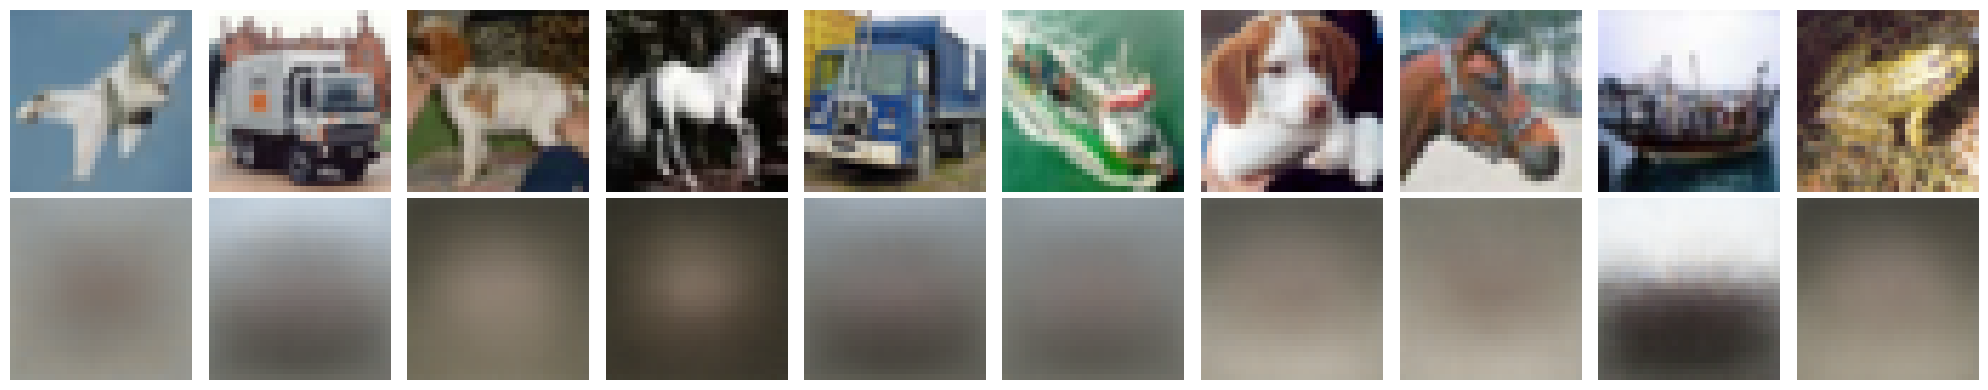

In [27]:

z_sample=vae_cifar.encoder.predict(x_test)[2]

images=vae_cifar.decoder.predict(z_sample)

images.shape

# Select 10 indices
indices = np.arange(10, 20)

# Plot the input vs output images
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

for i, idx in enumerate(indices):
    # Plot input image
    axes[0, i].imshow(x_test[idx].reshape(32, 32, 3))
    axes[0, i].axis('off')
    
    # Plot output image
    axes[1, i].imshow(images[idx].reshape(32, 32, 3))
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()



